In [1]:
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

In [2]:
X = pd.read_csv("data/processed/marketing_campaign_final.csv")
X = X.drop(columns='ID')

In [3]:
X.shape

(2029, 8)

### Pour trouver les bon paramètres

#### k-distance plot

1. Fixer `min_samples`
Règle empirique :
$$ \text{min\_samples} \geq \text{dim} + 1 $$

Donc, pour un dataset de 10 colonnes → essayer min_samples = 10, puis ajuster
Augmenter un peu si bruit important

2. Trouver le meilleur `eps` avec un `k-distance` `plot`

- Chercher l'“épaule” (le coude) dans la courbe.

- La valeur de `eps` est souvent celle où la courbe commence à monter fortement.

 C’est le même principe que l’“elbow method” pour le K-means.



### Modélisation

-1 correspond aux outliers

In [13]:
EPS = 7
MinSAMPLES = 11

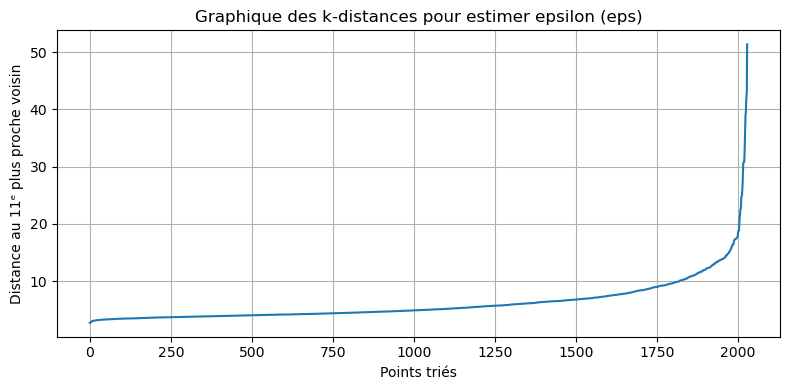

In [12]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=MinSAMPLES)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# On prend la distance au k-ième plus proche voisin
k_distances = np.sort(distances[:, -1])  # la colonne -1 = la plus grande distance pour chaque point

# Tracé du k-distance plot
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.xlabel("Points triés")
plt.ylabel(f"Distance au {MinSAMPLES}ᵉ plus proche voisin")
plt.title("Graphique des k-distances pour estimer epsilon (eps)")
plt.grid(True)
plt.tight_layout()



- `.fit()`, les labels sont stockés dans l’attribut `.labels_`

- `.fit_predict(X)` fait la même chose que `.fit(X)` et retourne directement les labels (`model.labels_`)

In [6]:

model = DBSCAN(eps=EPS, min_samples=MinSAMPLES)
labels = model.fit_predict(X)

X['cluster'] = labels
# Label de cluser pour chaque points
labels = model.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Nombre de clusters trouvés : {n_clusters}")

Nombre de clusters trouvés : 4


##### Palette de couleur pour les clusters

In [7]:
# Liste triée des clusters
clusters = sorted(X['cluster'].unique())

# Palette fixe (tab10 a 10 couleurs max)
palette = sns.color_palette("tab10", n_colors=len(clusters))

# Mapping cluster -> couleur
color_dict = {cluster: palette[i] for i, cluster in enumerate(clusters)}

#### Statistiques descriptives des clusters

In [8]:
cluster_stats = X.groupby('cluster').mean().T
display(cluster_stats)
# Pour voir la répartition des effectifs par cluster
print(X['cluster'].value_counts())

cluster,-1,0,1,2,3
PC1,23.120923,-4.100860,29.916049,26.908489,-18.404150
PC2,2.625752,-0.226604,-11.531123,14.799690,-29.844859
PC3,-5.937473,1.198845,-3.814842,-9.049693,-21.575376
Age,-0.113958,0.011970,0.331377,0.226190,0.134021
Income,0.502096,-0.090713,1.105149,0.426769,-0.686243
Total_Spending,0.730642,-0.137533,2.125125,0.564944,-0.912127
Has_Children,0.432234,0.773497,0.000000,0.642857,0.636364
Customer_Seniority,0.122236,-0.024077,0.209495,0.359973,-0.085147


cluster
 0    1713
-1     273
 1      18
 2      14
 3      11
Name: count, dtype: int64


### Métriques - évaluation

In [9]:
from sklearn.metrics import silhouette_score
mask = X['cluster'] != -1
if mask.sum() > 1 and len(set(X.loc[mask, 'cluster'])) > 1:
    sil_score = silhouette_score(X.loc[mask].drop('cluster', axis=1), X.loc[mask, 'cluster'])
    print(f"Silhouette score (hors outliers) : {sil_score:.3f}")
else:
    print("Pas assez de clusters ou de points pour calculer le score de silhouette.")

Silhouette score (hors outliers) : 0.216


### Visualisation
#### Affichage 2 D

Text(0.5, 0.98, 'Visualisation du clustering DBSCANen 2 D avec les 2 premières variables PCA')

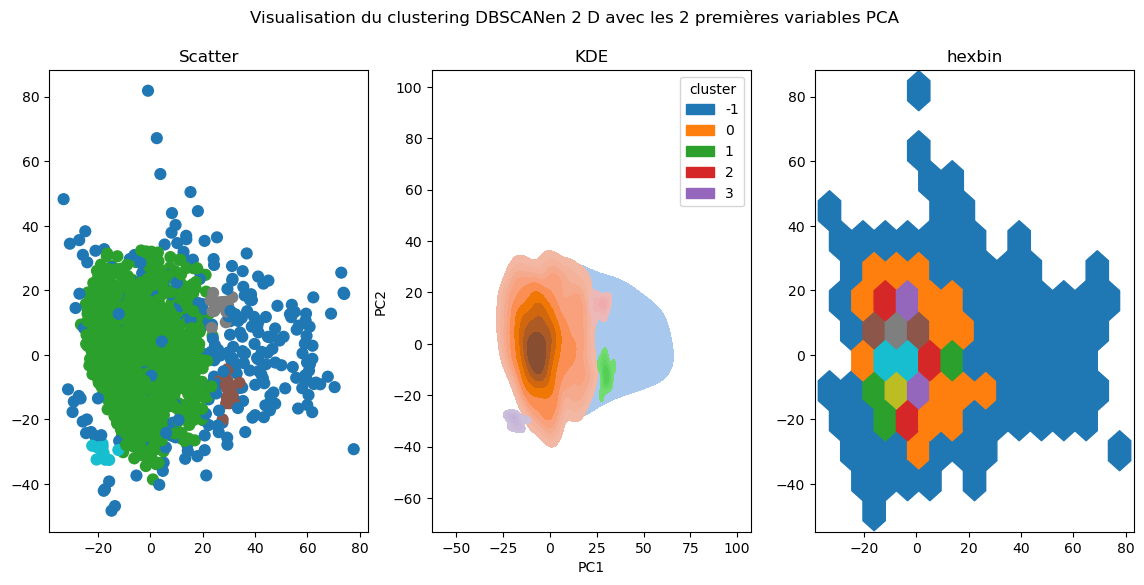

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

axs[0].scatter(X['PC1'], X['PC2'], c=X['cluster'], cmap='tab10', s=60)
axs[0].set_title("Scatter")
# axs[1].kdeplot(X['PC1'], X['PC2'], c=X['cluster'], cmap='tab10', s=60)
sns.kdeplot(
    data=X,
    x='PC1', y='PC2',
    hue='cluster',
    fill=True,
    palette='tab10',
    ax=axs[1]
)
axs[1].set_title("KDE")
axs[2].hexbin(X['PC1'], X['PC2'], gridsize=13, cmap='tab10', mincnt=1)
axs[2].set_title("hexbin")

plt.suptitle("Visualisation du clustering DBSCANen 2 D avec les 2 premières variables PCA")


#### Affichage 3 D

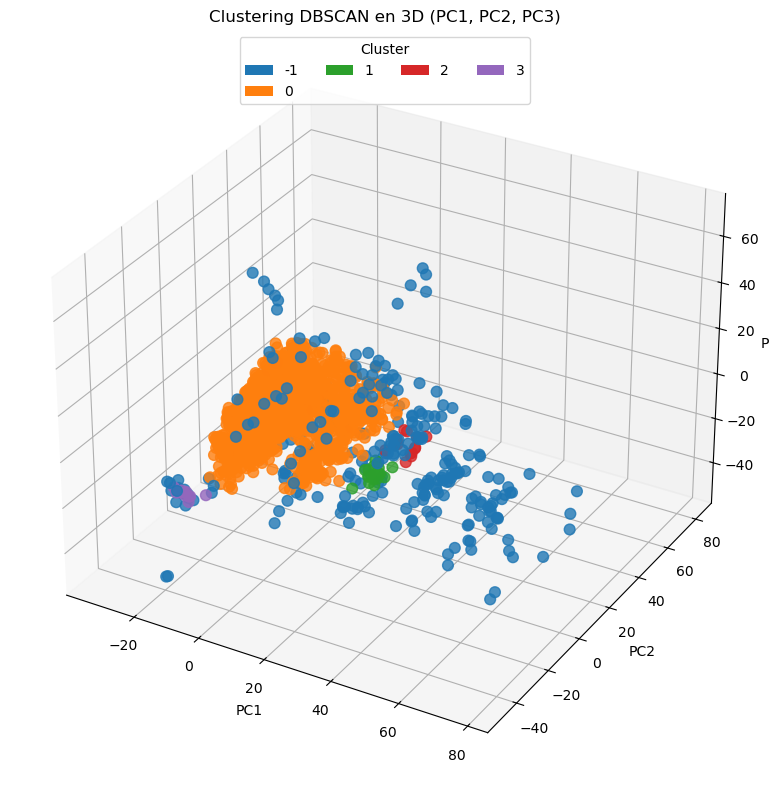

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Liste des couleurs correspondantes à chaque point
colors = X['cluster'].map(color_dict).to_list()

# Scatter 3D avec couleur selon cluster
scatter = ax.scatter(
    X['PC1'], X['PC2'], X['PC3'],
    c=colors,
    # cmap='tab10',
    s=60,
    alpha=0.8
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Clustering DBSCAN en 3D (PC1, PC2, PC3)")

# Création de la légende
# handles, labels = scatter.legend_elements()
# ax.legend(handles, labels, title="Cluster", loc='upper center', ncol=4)
legend_elements = [Patch(facecolor=color_dict[c], label=str(c)) for c in clusters]
ax.legend(handles=legend_elements, title="Cluster", loc='upper center', ncol=4)

plt.tight_layout()

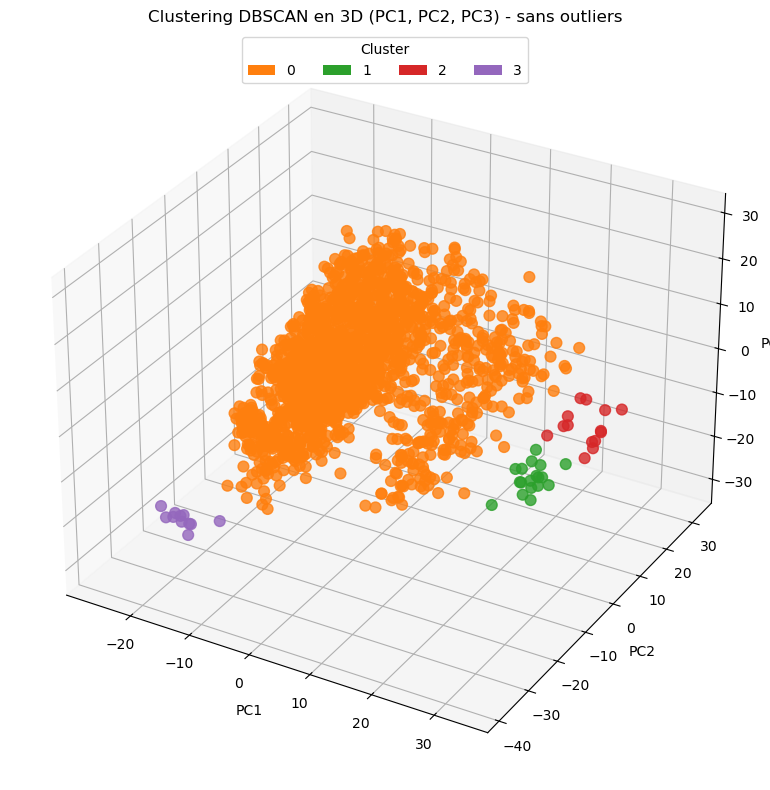

In [15]:
# Affichage 3D sans les outliers
mask = X['cluster'] != -1
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = X.loc[mask, 'cluster'].map(color_dict).to_list()
scatter = ax.scatter(
    X.loc[mask, 'PC1'], X.loc[mask, 'PC2'], X.loc[mask, 'PC3'],
    c=colors,
    s=60,
    alpha=0.8
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Clustering DBSCAN en 3D (PC1, PC2, PC3) - sans outliers")
legend_elements = [Patch(facecolor=color_dict[c], label=str(c)) for c in clusters if c != -1]
ax.legend(handles=legend_elements, title="Cluster", loc='upper center', ncol=4)
plt.tight_layout()

In [14]:
import plotly.express as px

# Convertit chaque couleur RGB (float 0-1) en hex pour plotly
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % tuple(int(255*x) for x in rgb)

color_discrete_map = {str(cluster): rgb_to_hex(color) for cluster, color in color_dict.items()}



fig = px.scatter_3d(
    X, x='PC1', y='PC2', z='PC3',
    color=X['cluster'].astype(str),
    title="Clustering DBSCAN en 3D",
    symbol='cluster',
    color_discrete_map={str(k): rgb_to_hex(v) for k, v in color_dict.items()}
)
fig.show()
